# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone git@github.com:jcmayoral/PyTorch-YOLOv3.git yolov3

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [2]:
from yolov3.models import Darknet

#model_4classes = Darknet(config_path="yolov3/config/yolov3-custom.cfg")

In [3]:
#nparams = sum(p.numel() for p in model_4classes.parameters())
#print (f"{nparams:,}")

In [4]:
!ls
!pwd

'attempt yolo-binary.ipynb'	   __pycache__
'attempt yolo.ipynb'		   rcnntutorial.ipynb
 checkpoints			   scalar
 coco_eval.py			   svmpersons.ipynb
 coco_utils.py			   testimageyolo.jpg
 decisiontreepersons.ipynb	   testingyolo
 engine.py			   transforms.py
 linearregressionpersons.ipynb	   utils.py
 logisticregressionpersons.ipynb   vision
 output				   yolov3
 pointnet.ipynb
/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [5]:
bs = 3
nepochs = 10
ncpu = 4
gradient_accumulations = 2
evaluation_interval = 2
checkpoint_interval = 10
img_size = 416

In [6]:
from __future__ import division

from yolov3.models import *
from yolov3.utils.logger import *
from yolov3.utils.utils import *
from yolov3.utils.datasets import *
from yolov3.utils.parse_config import *
from yolov3.test import evaluate

from terminaltables import AsciiTable

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim


"""
parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
parser.add_argument("--batch_size", type=int, default=8, help="size of each image batch")
parser.add_argument("--gradient_accumulations", type=int, default=2, help="number of gradient accums before step")
parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
parser.add_argument("--data_config", type=str, default="config/coco.data", help="path to data config file")
parser.add_argument("--pretrained_weights", type=str, help="if specified starts from checkpoint model")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
parser.add_argument("--checkpoint_interval", type=int, default=1, help="interval between saving model weights")
parser.add_argument("--evaluation_interval", type=int, default=1, help="interval evaluations on validation set")
parser.add_argument("--compute_map", default=False, help="if True computes mAP every tenth batch")
parser.add_argument("--multiscale_training", default=True, help="allow for multi-scale training")
opt = parser.parse_args()
print(opt)
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config("yolov3/config/josebinary.data")
#data_config = { line.split()[0] : line.split()[1] for line in open("yolov3/config/jose.data") }

#parse_data_config(opt.data_config)bb
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

print(class_names)

# Initiate model
model = Darknet("yolov3/config/yolov3-binarycustom.cfg", img_size=img_size).to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint
"""
if opt.pretrained_weights:
    if opt.pretrained_weights.endswith(".pth"):
        model.load_state_dict(torch.load(opt.pretrained_weights))
    else:
        model.load_darknet_weights(opt.pretrained_weights)
"""



/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jose/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

['Lethal', 'Safe']


'\nif opt.pretrained_weights:\n    if opt.pretrained_weights.endswith(".pth"):\n        model.load_state_dict(torch.load(opt.pretrained_weights))\n    else:\n        model.load_darknet_weights(opt.pretrained_weights)\n'

In [7]:
!pwd


/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [8]:
# Get dataloader
#For some reason augment or multiscale fails
dataset = ListDataset(train_path, augment=False, multiscale=False)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=ncpu,
    pin_memory=False,
    collate_fn=dataset.collate_fn,
)

optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

try:
    os.makedirs("testingyolo")
except:
    pass

#logger = Logger("testingyolo/logs")


for epoch in range(nepochs):
    model.train()
    start_time = time.time()
    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        #print(_)
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, nepochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        # Log metrics at each YOLO layer
        for i, metric in enumerate(metrics):
            formats = {m: "%.6f" for m in metrics}
            formats["grid_size"] = "%2d"
            formats["cls_acc"] = "%.2f%%"
            row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
            metric_table += [[metric, *row_metrics]]

            # Tensorboard logging
            tensorboard_log = []
            for j, yolo in enumerate(model.yolo_layers):
                for name, metric in yolo.metrics.items():
                    if name != "grid_size":
                        tensorboard_log += [(f"{name}_{j+1}", metric)]
            tensorboard_log += [("loss", loss.item())]
            #logger.list_of_scalars_summary(tensorboard_log, batches_done)

        log_str += AsciiTable(metric_table).table
        log_str += f"\nTotal loss {loss.item()}"

        # Determine approximate time left for epoch
        epoch_batches_left = len(dataloader) - (batch_i + 1)
        time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
        log_str += f"\n---- ETA {time_left}"

        print(log_str)

        model.seen += imgs.size(0)

    if epoch % evaluation_interval == 1:
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            path=valid_path,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=img_size,
            batch_size=bs,
        )
        """
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        logger.list_of_scalars_summary(evaluation_metrics, epoch)
        """
        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

    if epoch % checkpoint_interval == 0:
        torch.save(model.state_dict(), f"testingyolo/checkpoints/binaryyolov3_ckpt_%d.pth" % epoch)



---- [Epoch 0/10, Batch 0/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 66.760254    | 71.022636    | 74.556870    |
| x          | 0.081735     | 0.059475     | 0.087936     |
| y          | 0.099278     | 0.103123     | 0.098805     |
| w          | 0.587413     | 0.406362     | 0.287759     |
| h          | 0.449551     | 0.139307     | 4.244981     |
| conf       | 64.783157    | 69.761444    | 69.040421    |
| cls        | 0.759121     | 0.552924     | 0.796968     |
| cls_acc    | 50.00%       | 100.00%      | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.406679     | 0.439714     | 0.496005     |
| co


---- [Epoch 0/10, Batch 8/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 36.484196    | 42.508186    | 55.147697    |
| x          | 0.186119     | 0.044829     | 0.042177     |
| y          | 0.095324     | 0.071233     | 0.074880     |
| w          | 3.634365     | 0.337022     | 1.017016     |
| h          | 0.252965     | 0.515840     | 2.696610     |
| conf       | 31.619780    | 40.839249    | 50.632133    |
| cls        | 0.695640     | 0.700011     | 0.684882     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.213937     | 0.313158     | 0.433259     |
| co


---- [Epoch 0/10, Batch 16/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 18.043003    | 22.329367    | 35.160473    |
| x          | 0.016532     | 0.124979     | 0.024468     |
| y          | 0.064970     | 0.103141     | 0.021360     |
| w          | 3.154085     | 1.643711     | 0.088937     |
| h          | 3.067461     | 1.938998     | 0.100231     |
| conf       | 11.094327    | 18.113636    | 34.283432    |
| cls        | 0.645627     | 0.404902     | 0.642045     |
| cls_acc    | 66.67%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.120960     | 0.270989     | 0.287769     |
| c


---- [Epoch 0/10, Batch 24/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 6.533814     | 11.616331    | 25.475689    |
| x          | 0.088389     | 0.065886     | 0.099931     |
| y          | 0.060357     | 0.097933     | 0.107871     |
| w          | 0.195440     | 0.047083     | 0.057524     |
| h          | 0.354478     | 0.259651     | 0.051791     |
| conf       | 5.166883     | 10.202730    | 24.370050    |
| cls        | 0.668266     | 0.943047     | 0.788521     |
| cls_acc    | 75.00%       | 25.00%       | 25.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.088674     | 0.167513     | 0.229006     |
| c


---- [Epoch 0/10, Batch 32/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.405191     | 7.854744     | 18.621149    |
| x          | 0.032968     | 0.171712     | 0.103054     |
| y          | 0.103796     | 0.067595     | 0.012216     |
| w          | 0.295943     | 0.082510     | 0.034576     |
| h          | 0.265779     | 0.072502     | 0.024027     |
| conf       | 4.028177     | 6.879573     | 17.768513    |
| cls        | 0.678529     | 0.580853     | 0.678762     |
| cls_acc    | 75.00%       | 50.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.092000     | 0.215441     | 0.198442     |
| c


---- [Epoch 0/10, Batch 39/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.686284     | 6.156619     | 15.368141    |
| x          | 0.086383     | 0.031829     | 0.056716     |
| y          | 0.020557     | 0.063374     | 0.132475     |
| w          | 0.081527     | 0.179067     | 0.152310     |
| h          | 0.175073     | 0.043684     | 0.263024     |
| conf       | 3.818341     | 5.379356     | 14.111756    |
| cls        | 0.504403     | 0.459308     | 0.651859     |
| cls_acc    | 100.00%      | 75.00%       | 75.00%       |
| recall50   | 0.000000     | 0.250000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.333333     | 0.000000     |
| conf_obj   | 0.151826     | 0.268906     | 0.171838     |
| c


---- [Epoch 1/10, Batch 1/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.630402     | 5.531108     | 12.321447    |
| x          | 0.086156     | 0.105211     | 0.073222     |
| y          | 0.051692     | 0.061151     | 0.107614     |
| w          | 0.127923     | 0.153200     | 0.281559     |
| h          | 0.254289     | 0.043397     | 0.458675     |
| conf       | 3.605119     | 4.886300     | 10.694147    |
| cls        | 0.505224     | 0.281848     | 0.706230     |
| cls_acc    | 75.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.250000     | 0.000000     |
| recall75   | 0.000000     | 0.250000     | 0.000000     |
| precision  | 0.000000     | 0.032258     | 0.000000     |
| conf_obj   | 0.126875     | 0.323523     | 0.241977     |
| co


---- [Epoch 1/10, Batch 9/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.043624     | 4.683018     | 8.896943     |
| x          | 0.063485     | 0.018165     | 0.077056     |
| y          | 0.064282     | 0.013731     | 0.021999     |
| w          | 0.064984     | 0.033987     | 0.056521     |
| h          | 0.077834     | 0.110592     | 0.212298     |
| conf       | 3.135671     | 4.183383     | 7.802304     |
| cls        | 0.637368     | 0.323159     | 0.726765     |
| cls_acc    | 60.00%       | 80.00%       | 40.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.201648     | 0.178635     | 0.387254     |
| co


---- [Epoch 1/10, Batch 17/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.569687     | 4.201509     | 8.815880     |
| x          | 0.118725     | 0.115105     | 0.053466     |
| y          | 0.049217     | 0.029335     | 0.020230     |
| w          | 0.204539     | 0.159888     | 0.392286     |
| h          | 0.079190     | 0.213859     | 0.569784     |
| conf       | 3.781620     | 3.383440     | 7.033337     |
| cls        | 0.336396     | 0.299884     | 0.746777     |
| cls_acc    | 100.00%      | 100.00%      | 25.00%       |
| recall50   | 0.000000     | 0.250000     | 0.000000     |
| recall75   | 0.000000     | 0.250000     | 0.000000     |
| precision  | 0.000000     | 0.333333     | 0.000000     |
| conf_obj   | 0.136046     | 0.229334     | 0.232590     |
| c


---- [Epoch 1/10, Batch 24/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.154048     | 4.582351     | 7.359683     |
| x          | 0.113165     | 0.138592     | 0.115166     |
| y          | 0.111466     | 0.111258     | 0.089659     |
| w          | 0.095812     | 0.250733     | 0.251268     |
| h          | 0.319104     | 0.225972     | 0.311095     |
| conf       | 3.820620     | 3.164907     | 5.902870     |
| cls        | 0.693880     | 0.690889     | 0.689625     |
| cls_acc    | 40.00%       | 80.00%       | 80.00%       |
| recall50   | 0.000000     | 0.400000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.058824     | 0.000000     |
| conf_obj   | 0.109158     | 0.457159     | 0.339030     |
| c


---- [Epoch 1/10, Batch 31/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.920697     | 4.707902     | 6.599738     |
| x          | 0.065240     | 0.069347     | 0.109554     |
| y          | 0.100385     | 0.050896     | 0.112227     |
| w          | 0.086835     | 0.175251     | 0.050874     |
| h          | 0.046224     | 0.198618     | 0.240798     |
| conf       | 4.050135     | 3.258243     | 5.393576     |
| cls        | 0.571879     | 0.955547     | 0.692709     |
| cls_acc    | 60.00%       | 40.00%       | 60.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.092680     | 0.353577     | 0.338132     |
| c


---- [Epoch 1/10, Batch 38/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.220244     | 2.624994     | 4.815591     |
| x          | 0.016319     | 0.097788     | 0.129719     |
| y          | 0.132227     | 0.112403     | 0.113797     |
| w          | 0.069959     | 0.025604     | 0.057271     |
| h          | 0.308053     | 0.014360     | 0.067058     |
| conf       | 2.817776     | 1.965177     | 3.757692     |
| cls        | 0.875912     | 0.409661     | 0.690052     |
| cls_acc    | 33.33%       | 100.00%      | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.000000     | 0.090909     | 0.024390     |
| conf_obj   | 0.191326     | 0.522146     | 0.600227     |
| c

Detecting objects:   0%|          | 0/10 [00:00<?, ?it/s]


---- [Epoch 1/10, Batch 45/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.452814     | 2.463373     | 4.517341     |
| x          | 0.006867     | 0.116375     | 0.080792     |
| y          | 0.025110     | 0.035598     | 0.002014     |
| w          | 0.063340     | 0.009556     | 0.002830     |
| h          | 0.009599     | 0.032285     | 0.003975     |
| conf       | 3.949872     | 1.679553     | 3.744140     |
| cls        | 0.398027     | 0.590006     | 0.683590     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 1.000000     | 0.500000     |
| recall75   | 0.000000     | 0.500000     | 0.500000     |
| precision  | 0.000000     | 0.153846     | 0.022222     |
| conf_obj   | 0.099576     | 0.709088     | 0.508316     |
| c

Computing AP: 100%|██████████| 2/2 [00:00<00:00, 4398.85it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.06061 |
| 1     | Safe       | 0.05556 |
+-------+------------+---------+
---- mAP 0.05808080808080808



---- [Epoch 2/10, Batch 0/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.888084     | 2.987983     | 4.854039     |
| x          | 0.071157     | 0.007054     | 0.096381     |
| y          | 0.032382     | 0.035582     | 0.074770     |
| w          | 0.043585     | 0.060422     | 0.157407     |
| h          | 0.046619     | 0.072018     | 0.184430     |
| conf       | 3.120736     | 2.389639     | 3.718562     |
| cls        | 0.573606     | 0.423268     | 0.622489     |
| cls_acc    | 50.00%       | 100.00%      | 75.00%       |
| recall50   | 0.000000     | 0.750000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.200000     | 0.000000     |
| conf_obj   | 0.176207     | 0.533290     | 0.497790     |
| co


---- [Epoch 2/10, Batch 8/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.491821     | 3.092959     | 4.653378     |
| x          | 0.017499     | 0.107802     | 0.074491     |
| y          | 0.047985     | 0.031477     | 0.055980     |
| w          | 0.041889     | 0.099914     | 0.293437     |
| h          | 0.072118     | 0.108845     | 0.226605     |
| conf       | 2.725363     | 2.503495     | 3.153312     |
| cls        | 0.586967     | 0.241426     | 0.849553     |
| cls_acc    | 100.00%      | 100.00%      | 25.00%       |
| recall50   | 0.000000     | 0.250000     | 0.250000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.100000     | 0.058824     |
| conf_obj   | 0.196001     | 0.332215     | 0.493042     |
| co


---- [Epoch 2/10, Batch 15/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.882701     | 3.856883     | 5.690128     |
| x          | 0.121941     | 0.112677     | 0.099106     |
| y          | 0.024966     | 0.012819     | 0.042896     |
| w          | 0.304194     | 0.261271     | 0.590537     |
| h          | 0.476388     | 0.205742     | 0.482388     |
| conf       | 3.422501     | 3.141451     | 3.766150     |
| cls        | 0.532711     | 0.122922     | 0.709051     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.166667     | 0.000000     |
| conf_obj   | 0.093116     | 0.297002     | 0.313545     |
| c


---- [Epoch 2/10, Batch 22/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.854069     | 2.766267     | 3.723921     |
| x          | 0.051073     | 0.112122     | 0.084141     |
| y          | 0.049284     | 0.074905     | 0.121037     |
| w          | 0.011826     | 0.065083     | 0.028655     |
| h          | 0.085455     | 0.039073     | 0.087919     |
| conf       | 2.815057     | 1.876329     | 2.764672     |
| cls        | 0.841374     | 0.598753     | 0.637496     |
| cls_acc    | 33.33%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.666667     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.000000     | 0.125000     | 0.052632     |
| conf_obj   | 0.187481     | 0.718268     | 0.506162     |
| c


---- [Epoch 2/10, Batch 29/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.212212     | 3.514957     | 4.912667     |
| x          | 0.144834     | 0.070617     | 0.052983     |
| y          | 0.031329     | 0.065447     | 0.074825     |
| w          | 0.148704     | 0.130859     | 0.280121     |
| h          | 0.573572     | 0.135872     | 0.184757     |
| conf       | 3.936090     | 2.832119     | 3.659150     |
| cls        | 0.377684     | 0.280043     | 0.660832     |
| cls_acc    | 100.00%      | 80.00%       | 60.00%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.149738     | 0.307741     | 0.401265     |
| c


---- [Epoch 2/10, Batch 36/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.907640     | 4.737034     | 4.409734     |
| x          | 0.047574     | 0.145233     | 0.057305     |
| y          | 0.047102     | 0.017431     | 0.130315     |
| w          | 0.091496     | 0.017740     | 0.089367     |
| h          | 0.126058     | 0.300194     | 0.244356     |
| conf       | 4.117815     | 3.187569     | 3.291288     |
| cls        | 0.477595     | 1.068867     | 0.597104     |
| cls_acc    | 75.00%       | 50.00%       | 75.00%       |
| recall50   | 0.000000     | 0.250000     | 0.250000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.100000     | 0.027027     |
| conf_obj   | 0.125553     | 0.336613     | 0.350940     |
| c


---- [Epoch 2/10, Batch 43/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.608191     | 2.095759     | 3.175401     |
| x          | 0.012163     | 0.030843     | 0.067078     |
| y          | 0.023852     | 0.089147     | 0.034829     |
| w          | 0.122167     | 0.018509     | 0.015623     |
| h          | 0.309778     | 0.017197     | 0.025824     |
| conf       | 2.409577     | 1.382658     | 2.279774     |
| cls        | 0.730654     | 0.557404     | 0.752273     |
| cls_acc    | 66.67%       | 100.00%      | 33.33%       |
| recall50   | 0.000000     | 1.000000     | 0.333333     |
| recall75   | 0.000000     | 0.666667     | 0.333333     |
| precision  | 0.000000     | 0.150000     | 0.016393     |
| conf_obj   | 0.250738     | 0.753558     | 0.689358     |
| c


---- [Epoch 3/10, Batch 5/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.750442     | 2.592996     | 3.371304     |
| x          | 0.044739     | 0.108869     | 0.073545     |
| y          | 0.028549     | 0.026328     | 0.097325     |
| w          | 0.036200     | 0.038975     | 0.210603     |
| h          | 0.036386     | 0.121973     | 0.137220     |
| conf       | 2.155121     | 1.934379     | 2.144349     |
| cls        | 0.449447     | 0.362472     | 0.708263     |
| cls_acc    | 80.00%       | 80.00%       | 20.00%       |
| recall50   | 0.000000     | 0.200000     | 0.200000     |
| recall75   | 0.000000     | 0.000000     | 0.200000     |
| precision  | 0.000000     | 0.111111     | 0.021739     |
| conf_obj   | 0.270485     | 0.395577     | 0.625850     |
| co


---- [Epoch 3/10, Batch 13/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.154885     | 4.493436     | 4.720053     |
| x          | 0.102380     | 0.074470     | 0.148402     |
| y          | 0.085060     | 0.059837     | 0.125036     |
| w          | 0.119544     | 0.176514     | 0.091898     |
| h          | 0.364622     | 0.101001     | 0.176104     |
| conf       | 3.095642     | 3.553548     | 3.703061     |
| cls        | 0.387638     | 0.528065     | 0.475553     |
| cls_acc    | 75.00%       | 50.00%       | 75.00%       |
| recall50   | 0.250000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.000000     | 0.000000     |
| conf_obj   | 0.222143     | 0.189137     | 0.424681     |
| c


---- [Epoch 3/10, Batch 21/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.790413     | 3.018013     | 3.195479     |
| x          | 0.030734     | 0.024891     | 0.133533     |
| y          | 0.018128     | 0.019590     | 0.055623     |
| w          | 0.173691     | 0.097025     | 0.009682     |
| h          | 0.114627     | 0.238701     | 0.025205     |
| conf       | 2.866274     | 2.108422     | 2.495181     |
| cls        | 0.586959     | 0.529384     | 0.476255     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.000000     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.333333     |
| precision  | 0.000000     | 0.166667     | 0.047619     |
| conf_obj   | 0.101438     | 0.421074     | 0.492260     |
| c


---- [Epoch 3/10, Batch 28/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.792967     | 2.742429     | 3.068949     |
| x          | 0.061465     | 0.017462     | 0.093684     |
| y          | 0.019450     | 0.060750     | 0.032026     |
| w          | 0.073716     | 0.076397     | 0.096479     |
| h          | 0.182016     | 0.057780     | 0.022315     |
| conf       | 3.003530     | 2.003748     | 2.306464     |
| cls        | 0.452789     | 0.526291     | 0.517980     |
| cls_acc    | 75.00%       | 50.00%       | 75.00%       |
| recall50   | 0.250000     | 0.000000     | 0.250000     |
| recall75   | 0.250000     | 0.000000     | 0.250000     |
| precision  | 0.111111     | 0.000000     | 0.016949     |
| conf_obj   | 0.352435     | 0.499517     | 0.574514     |
| c


---- [Epoch 3/10, Batch 36/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.410224     | 2.846128     | 3.229913     |
| x          | 0.073447     | 0.051081     | 0.038090     |
| y          | 0.053377     | 0.025604     | 0.070636     |
| w          | 0.048938     | 0.032369     | 0.054709     |
| h          | 0.243436     | 0.133976     | 0.066390     |
| conf       | 2.526425     | 2.204902     | 2.614529     |
| cls        | 0.464600     | 0.398196     | 0.385558     |
| cls_acc    | 75.00%       | 75.00%       | 100.00%      |
| recall50   | 0.000000     | 0.250000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.250000     |
| precision  | 0.000000     | 0.090909     | 0.041667     |
| conf_obj   | 0.147461     | 0.386050     | 0.408107     |
| c


---- [Epoch 3/10, Batch 44/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.052469     | 2.500932     | 3.254642     |
| x          | 0.082532     | 0.023171     | 0.125350     |
| y          | 0.058979     | 0.031075     | 0.064038     |
| w          | 0.022184     | 0.020601     | 0.038551     |
| h          | 0.040297     | 0.178550     | 0.071437     |
| conf       | 2.432352     | 1.886895     | 2.549480     |
| cls        | 0.416125     | 0.360640     | 0.405786     |
| cls_acc    | 75.00%       | 75.00%       | 100.00%      |
| recall50   | 0.250000     | 0.000000     | 0.500000     |
| recall75   | 0.250000     | 0.000000     | 0.250000     |
| precision  | 0.200000     | 0.000000     | 0.060606     |
| conf_obj   | 0.325994     | 0.407135     | 0.472679     |
| c

Detecting objects:   0%|          | 0/10 [00:00<?, ?it/s]


---- [Epoch 3/10, Batch 45/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.428155     | 2.599508     | 2.840212     |
| x          | 0.030596     | 0.059912     | 0.036389     |
| y          | 0.020569     | 0.024538     | 0.066249     |
| w          | 0.111671     | 0.099759     | 0.005148     |
| h          | 0.004437     | 0.121860     | 0.007125     |
| conf       | 1.785857     | 1.927033     | 2.288873     |
| cls        | 0.475024     | 0.366406     | 0.436427     |
| cls_acc    | 50.00%       | 100.00%      | 50.00%       |
| recall50   | 0.000000     | 0.500000     | 0.000000     |
| recall75   | 0.000000     | 0.500000     | 0.000000     |
| precision  | 0.000000     | 0.200000     | 0.000000     |
| conf_obj   | 0.447911     | 0.482903     | 0.523151     |
| c

Computing AP: 100%|██████████| 2/2 [00:00<00:00, 2326.94it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.63220 |
| 1     | Safe       | 0.25000 |
+-------+------------+---------+
---- mAP 0.44109793782207574



---- [Epoch 4/10, Batch 0/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.610023     | 3.079437     | 3.732870     |
| x          | 0.044472     | 0.002312     | 0.153194     |
| y          | 0.065763     | 0.061837     | 0.055528     |
| w          | 0.033928     | 0.116904     | 0.097850     |
| h          | 0.056439     | 0.003215     | 0.011038     |
| conf       | 2.887902     | 2.584501     | 2.846848     |
| cls        | 0.521519     | 0.310667     | 0.568412     |
| cls_acc    | 33.33%       | 100.00%      | 33.33%       |
| recall50   | 0.000000     | 0.666667     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.222222     | 0.000000     |
| conf_obj   | 0.388891     | 0.498293     | 0.563032     |
| co


---- [Epoch 4/10, Batch 8/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 4.132541     | 2.644153     | 3.843690     |
| x          | 0.053582     | 0.088711     | 0.086901     |
| y          | 0.044683     | 0.038871     | 0.176535     |
| w          | 0.307285     | 0.163034     | 0.166649     |
| h          | 0.270906     | 0.048139     | 0.224417     |
| conf       | 3.002953     | 1.918555     | 2.740952     |
| cls        | 0.453132     | 0.386844     | 0.448237     |
| cls_acc    | 80.00%       | 60.00%       | 80.00%       |
| recall50   | 0.000000     | 0.400000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.117647     | 0.000000     |
| conf_obj   | 0.220393     | 0.605236     | 0.402813     |
| co


---- [Epoch 4/10, Batch 16/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.772527     | 2.024957     | 2.646285     |
| x          | 0.026585     | 0.032598     | 0.129329     |
| y          | 0.002378     | 0.027885     | 0.046439     |
| w          | 0.399605     | 0.021922     | 0.003728     |
| h          | 0.258386     | 0.088691     | 0.052043     |
| conf       | 1.589955     | 1.537676     | 1.917309     |
| cls        | 0.495618     | 0.316185     | 0.497436     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.333333     | 0.666667     | 0.333333     |
| recall75   | 0.333333     | 0.333333     | 0.000000     |
| precision  | 0.250000     | 0.333333     | 0.030303     |
| conf_obj   | 0.528096     | 0.499290     | 0.631597     |
| c


---- [Epoch 4/10, Batch 23/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.957860     | 3.558983     | 3.856186     |
| x          | 0.032511     | 0.125822     | 0.068132     |
| y          | 0.034594     | 0.117704     | 0.016743     |
| w          | 0.057717     | 0.267050     | 0.242426     |
| h          | 0.031831     | 0.389763     | 0.150621     |
| conf       | 1.777904     | 2.443678     | 3.140981     |
| cls        | 0.023302     | 0.214966     | 0.237283     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.400000     | 0.000000     | 0.000000     |
| conf_obj   | 0.486180     | 0.264989     | 0.161496     |
| c


---- [Epoch 4/10, Batch 31/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.359032     | 2.169106     | 2.980604     |
| x          | 0.042011     | 0.062602     | 0.062288     |
| y          | 0.040878     | 0.048910     | 0.081923     |
| w          | 0.030356     | 0.034526     | 0.045015     |
| h          | 0.043408     | 0.195688     | 0.122845     |
| conf       | 1.657218     | 1.270849     | 2.128881     |
| cls        | 0.545161     | 0.556532     | 0.539653     |
| cls_acc    | 33.33%       | 66.67%       | 66.67%       |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.142857     | 0.035714     |
| conf_obj   | 0.447764     | 0.620311     | 0.480457     |
| c


---- [Epoch 4/10, Batch 39/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.411045     | 1.951912     | 2.661004     |
| x          | 0.188983     | 0.018340     | 0.037708     |
| y          | 0.042604     | 0.043103     | 0.113060     |
| w          | 0.046317     | 0.028460     | 0.140715     |
| h          | 0.023282     | 0.010838     | 0.188828     |
| conf       | 1.459958     | 0.998365     | 1.533220     |
| cls        | 0.649902     | 0.852806     | 0.647473     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.666667     | 0.333333     |
| recall75   | 0.000000     | 0.666667     | 0.000000     |
| precision  | 0.285714     | 0.125000     | 0.012658     |
| conf_obj   | 0.586095     | 0.806564     | 0.796827     |
| c


---- [Epoch 5/10, Batch 1/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 5.434438     | 3.850551     | 3.644780     |
| x          | 0.093151     | 0.022383     | 0.069112     |
| y          | 0.008617     | 0.024776     | 0.002971     |
| w          | 0.735619     | 0.135879     | 0.212437     |
| h          | 0.843018     | 0.462860     | 0.124724     |
| conf       | 3.525066     | 3.147505     | 3.065837     |
| cls        | 0.228967     | 0.057148     | 0.169700     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.333333     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.111111     | 0.000000     |
| conf_obj   | 0.174490     | 0.307016     | 0.297243     |
| co


---- [Epoch 5/10, Batch 9/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.718894     | 3.094689     | 3.223561     |
| x          | 0.105596     | 0.089304     | 0.064476     |
| y          | 0.063031     | 0.047761     | 0.037655     |
| w          | 0.093992     | 0.038948     | 0.045161     |
| h          | 0.028357     | 0.040184     | 0.139864     |
| conf       | 2.970531     | 2.536477     | 2.563855     |
| cls        | 0.457387     | 0.342015     | 0.372551     |
| cls_acc    | 75.00%       | 75.00%       | 100.00%      |
| recall50   | 0.500000     | 0.250000     | 0.500000     |
| recall75   | 0.000000     | 0.000000     | 0.500000     |
| precision  | 0.285714     | 0.125000     | 0.051282     |
| conf_obj   | 0.396875     | 0.429077     | 0.556861     |
| co


---- [Epoch 5/10, Batch 17/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.306252     | 2.893866     | 2.834505     |
| x          | 0.075167     | 0.033999     | 0.071697     |
| y          | 0.039238     | 0.002231     | 0.015728     |
| w          | 0.074665     | 0.009146     | 0.038921     |
| h          | 0.113080     | 0.004609     | 0.024990     |
| conf       | 1.577800     | 2.262169     | 2.251153     |
| cls        | 0.426303     | 0.581712     | 0.432016     |
| cls_acc    | 100.00%      | 75.00%       | 75.00%       |
| recall50   | 0.250000     | 0.250000     | 0.250000     |
| recall75   | 0.250000     | 0.250000     | 0.000000     |
| precision  | 0.500000     | 0.066667     | 0.019608     |
| conf_obj   | 0.404063     | 0.453511     | 0.465533     |
| c


---- [Epoch 5/10, Batch 25/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.183269     | 2.862945     | 3.548589     |
| x          | 0.080199     | 0.032710     | 0.030301     |
| y          | 0.106355     | 0.111892     | 0.067205     |
| w          | 0.163219     | 0.071834     | 0.020648     |
| h          | 0.023233     | 0.223399     | 0.059540     |
| conf       | 2.400492     | 2.127327     | 3.085111     |
| cls        | 0.409770     | 0.295783     | 0.285784     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 0.666667     | 0.666667     |
| recall75   | 0.333333     | 0.666667     | 0.666667     |
| precision  | 0.500000     | 0.222222     | 0.040000     |
| conf_obj   | 0.471274     | 0.578861     | 0.495538     |
| c


---- [Epoch 5/10, Batch 32/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.462362     | 1.975882     | 2.889271     |
| x          | 0.075120     | 0.018573     | 0.023757     |
| y          | 0.015722     | 0.084024     | 0.123593     |
| w          | 0.069542     | 0.016260     | 0.405617     |
| h          | 0.084792     | 0.075885     | 0.296249     |
| conf       | 1.704009     | 1.366253     | 1.441254     |
| cls        | 0.513178     | 0.414888     | 0.598801     |
| cls_acc    | 50.00%       | 75.00%       | 50.00%       |
| recall50   | 0.250000     | 0.250000     | 0.000000     |
| recall75   | 0.000000     | 0.250000     | 0.000000     |
| precision  | 0.166667     | 0.111111     | 0.000000     |
| conf_obj   | 0.560472     | 0.560912     | 0.649213     |
| c


---- [Epoch 5/10, Batch 40/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.624371     | 1.737146     | 2.279365     |
| x          | 0.035818     | 0.054722     | 0.059850     |
| y          | 0.009453     | 0.048079     | 0.048538     |
| w          | 0.057683     | 0.037968     | 0.179116     |
| h          | 0.007537     | 0.069376     | 0.204245     |
| conf       | 0.897992     | 1.091418     | 1.224868     |
| cls        | 0.615888     | 0.435583     | 0.562748     |
| cls_acc    | 50.00%       | 75.00%       | 75.00%       |
| recall50   | 0.250000     | 0.500000     | 0.500000     |
| recall75   | 0.250000     | 0.250000     | 0.250000     |
| precision  | 0.250000     | 0.166667     | 0.043478     |
| conf_obj   | 0.720018     | 0.716956     | 0.724000     |
| c

Detecting objects:   0%|          | 0/10 [00:00<?, ?it/s]


---- [Epoch 5/10, Batch 45/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.136372     | 2.162517     | 3.345042     |
| x          | 0.049106     | 0.013588     | 0.095376     |
| y          | 0.014297     | 0.111478     | 0.045365     |
| w          | 0.070669     | 0.033896     | 0.246643     |
| h          | 0.060997     | 0.080324     | 0.337756     |
| conf       | 1.577160     | 1.438998     | 1.837845     |
| cls        | 0.364144     | 0.484234     | 0.782057     |
| cls_acc    | 75.00%       | 75.00%       | 25.00%       |
| recall50   | 0.000000     | 0.250000     | 0.250000     |
| recall75   | 0.000000     | 0.250000     | 0.000000     |
| precision  | 0.000000     | 0.090909     | 0.029412     |
| conf_obj   | 0.406500     | 0.575840     | 0.562196     |
| c

Computing AP: 100%|██████████| 2/2 [00:00<00:00, 2837.82it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.37145 |
| 1     | Safe       | 0.69737 |
+-------+------------+---------+
---- mAP 0.5344113241051193



---- [Epoch 6/10, Batch 0/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.493816     | 2.200005     | 2.832131     |
| x          | 0.026158     | 0.064779     | 0.103552     |
| y          | 0.011537     | 0.099552     | 0.076628     |
| w          | 0.021967     | 0.286705     | 0.164870     |
| h          | 0.077397     | 0.135395     | 0.085067     |
| conf       | 1.709397     | 1.278435     | 1.950530     |
| cls        | 0.647360     | 0.335140     | 0.451483     |
| cls_acc    | 33.33%       | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.666667     | 0.666667     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.117647     | 0.054054     |
| conf_obj   | 0.414119     | 0.660207     | 0.517081     |
| co


---- [Epoch 6/10, Batch 8/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.862153     | 1.859778     | 2.057320     |
| x          | 0.094987     | 0.041527     | 0.012991     |
| y          | 0.039400     | 0.029573     | 0.079116     |
| w          | 0.079569     | 0.107532     | 0.032130     |
| h          | 0.135464     | 0.135161     | 0.079081     |
| conf       | 1.626526     | 1.255116     | 1.235311     |
| cls        | 0.886207     | 0.290870     | 0.618692     |
| cls_acc    | 50.00%       | 75.00%       | 50.00%       |
| recall50   | 0.000000     | 0.000000     | 0.250000     |
| recall75   | 0.000000     | 0.000000     | 0.250000     |
| precision  | 0.000000     | 0.000000     | 0.027778     |
| conf_obj   | 0.414598     | 0.540498     | 0.705106     |
| co


---- [Epoch 6/10, Batch 16/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.735156     | 1.753383     | 2.181534     |
| x          | 0.024804     | 0.125800     | 0.066836     |
| y          | 0.061899     | 0.087608     | 0.113826     |
| w          | 0.118271     | 0.026439     | 0.197171     |
| h          | 0.063571     | 0.004781     | 0.088552     |
| conf       | 1.120871     | 1.095824     | 1.165217     |
| cls        | 0.345740     | 0.412930     | 0.549932     |
| cls_acc    | 100.00%      | 75.00%       | 100.00%      |
| recall50   | 0.750000     | 0.250000     | 0.750000     |
| recall75   | 0.000000     | 0.250000     | 0.000000     |
| precision  | 0.500000     | 0.142857     | 0.066667     |
| conf_obj   | 0.687908     | 0.633880     | 0.825067     |
| c


---- [Epoch 6/10, Batch 24/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.001994     | 2.155125     | 2.344012     |
| x          | 0.047530     | 0.040015     | 0.102077     |
| y          | 0.072027     | 0.046644     | 0.108691     |
| w          | 0.026008     | 0.053842     | 0.045491     |
| h          | 0.023417     | 0.034607     | 0.051428     |
| conf       | 1.224270     | 1.576290     | 1.368536     |
| cls        | 0.608742     | 0.403727     | 0.667790     |
| cls_acc    | 80.00%       | 80.00%       | 60.00%       |
| recall50   | 0.400000     | 0.600000     | 0.400000     |
| recall75   | 0.400000     | 0.200000     | 0.200000     |
| precision  | 0.285714     | 0.150000     | 0.028571     |
| conf_obj   | 0.634098     | 0.577813     | 0.715369     |
| c


---- [Epoch 6/10, Batch 32/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.558503     | 2.840378     | 3.376307     |
| x          | 0.020493     | 0.093303     | 0.020436     |
| y          | 0.023458     | 0.012265     | 0.031773     |
| w          | 0.113300     | 0.149278     | 0.125291     |
| h          | 0.030348     | 0.146230     | 0.046167     |
| conf       | 2.214053     | 2.403565     | 2.983524     |
| cls        | 0.156852     | 0.035737     | 0.169116     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.333333     | 0.333333     | 0.333333     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 1.000000     | 0.166667     | 0.050000     |
| conf_obj   | 0.336911     | 0.278003     | 0.292820     |
| c


---- [Epoch 6/10, Batch 40/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.464039     | 1.860575     | 2.074635     |
| x          | 0.033457     | 0.068631     | 0.109843     |
| y          | 0.013868     | 0.071959     | 0.040370     |
| w          | 0.012257     | 0.224095     | 0.080450     |
| h          | 0.038089     | 0.085755     | 0.069904     |
| conf       | 0.899167     | 0.989912     | 1.200582     |
| cls        | 0.467202     | 0.420223     | 0.573486     |
| cls_acc    | 80.00%       | 80.00%       | 40.00%       |
| recall50   | 0.600000     | 0.600000     | 0.200000     |
| recall75   | 0.400000     | 0.000000     | 0.200000     |
| precision  | 0.600000     | 0.176471     | 0.016667     |
| conf_obj   | 0.785275     | 0.763185     | 0.888353     |
| c


---- [Epoch 7/10, Batch 2/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.185086     | 2.811057     | 2.997605     |
| x          | 0.037351     | 0.027276     | 0.057543     |
| y          | 0.011492     | 0.036912     | 0.106139     |
| w          | 0.301775     | 0.205509     | 0.011444     |
| h          | 0.042562     | 0.031980     | 0.078091     |
| conf       | 1.298328     | 1.868769     | 2.219073     |
| cls        | 0.493578     | 0.640610     | 0.525316     |
| cls_acc    | 75.00%       | 50.00%       | 50.00%       |
| recall50   | 0.500000     | 0.250000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.062500     | 0.000000     |
| conf_obj   | 0.637652     | 0.615533     | 0.538899     |
| co


---- [Epoch 7/10, Batch 10/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.165327     | 1.929498     | 1.537186     |
| x          | 0.023302     | 0.023026     | 0.095102     |
| y          | 0.019814     | 0.010430     | 0.019183     |
| w          | 0.228016     | 0.295496     | 0.018213     |
| h          | 0.330481     | 0.140604     | 0.037718     |
| conf       | 1.275610     | 1.206165     | 0.933563     |
| cls        | 0.288104     | 0.253776     | 0.433407     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.750000     | 0.500000     | 1.000000     |
| recall75   | 0.250000     | 0.000000     | 0.500000     |
| precision  | 0.428571     | 0.250000     | 0.117647     |
| conf_obj   | 0.541700     | 0.560570     | 0.845657     |
| c


---- [Epoch 7/10, Batch 18/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.884403     | 1.530090     | 1.712570     |
| x          | 0.066289     | 0.054359     | 0.071145     |
| y          | 0.009134     | 0.041804     | 0.072369     |
| w          | 0.092402     | 0.052139     | 0.156877     |
| h          | 0.071782     | 0.030439     | 0.016818     |
| conf       | 1.090130     | 1.136365     | 0.992157     |
| cls        | 0.554667     | 0.214983     | 0.403203     |
| cls_acc    | 50.00%       | 100.00%      | 100.00%      |
| recall50   | 0.250000     | 1.000000     | 1.000000     |
| recall75   | 0.250000     | 0.500000     | 0.250000     |
| precision  | 0.125000     | 0.173913     | 0.108108     |
| conf_obj   | 0.770062     | 0.757358     | 0.774453     |
| c


---- [Epoch 7/10, Batch 26/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.754578     | 1.751187     | 1.866931     |
| x          | 0.084670     | 0.026992     | 0.111666     |
| y          | 0.041793     | 0.049787     | 0.092130     |
| w          | 0.568759     | 0.067699     | 0.022297     |
| h          | 0.601940     | 0.171552     | 0.044176     |
| conf       | 1.099814     | 1.069846     | 1.148785     |
| cls        | 0.357603     | 0.365311     | 0.447877     |
| cls_acc    | 100.00%      | 100.00%      | 75.00%       |
| recall50   | 0.500000     | 1.000000     | 0.750000     |
| recall75   | 0.000000     | 0.250000     | 0.500000     |
| precision  | 0.333333     | 0.210526     | 0.041667     |
| conf_obj   | 0.676083     | 0.791912     | 0.883487     |
| c


---- [Epoch 7/10, Batch 34/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.941534     | 2.141441     | 2.435971     |
| x          | 0.107184     | 0.130716     | 0.157311     |
| y          | 0.022024     | 0.035794     | 0.021743     |
| w          | 0.508907     | 0.079452     | 0.077822     |
| h          | 0.146189     | 0.056678     | 0.224141     |
| conf       | 1.764515     | 1.244927     | 1.719186     |
| cls        | 0.392715     | 0.593872     | 0.235767     |
| cls_acc    | 66.67%       | 66.67%       | 100.00%      |
| recall50   | 0.333333     | 0.333333     | 0.666667     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.333333     | 0.166667     | 0.051282     |
| conf_obj   | 0.412211     | 0.522878     | 0.542171     |
| c


---- [Epoch 7/10, Batch 42/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.707834     | 1.348427     | 1.349768     |
| x          | 0.171441     | 0.015332     | 0.021697     |
| y          | 0.014859     | 0.041878     | 0.010761     |
| w          | 0.058163     | 0.173669     | 0.127739     |
| h          | 0.043999     | 0.115793     | 0.023164     |
| conf       | 0.864342     | 0.781931     | 0.985612     |
| cls        | 0.555030     | 0.219823     | 0.180795     |
| cls_acc    | 66.67%       | 100.00%      | 100.00%      |
| recall50   | 0.666667     | 1.000000     | 1.000000     |
| recall75   | 0.000000     | 0.000000     | 0.333333     |
| precision  | 0.500000     | 0.250000     | 0.078947     |
| conf_obj   | 0.744698     | 0.808493     | 0.771595     |
| c

Detecting objects:   0%|          | 0/10 [00:00<?, ?it/s]


---- [Epoch 7/10, Batch 45/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.271952     | 2.251666     | 2.120394     |
| x          | 0.030922     | 0.070010     | 0.039959     |
| y          | 0.041813     | 0.112882     | 0.111701     |
| w          | 0.012175     | 0.134475     | 0.023342     |
| h          | 0.052584     | 0.104656     | 0.020020     |
| conf       | 1.611826     | 1.182280     | 1.262855     |
| cls        | 0.522631     | 0.647363     | 0.662517     |
| cls_acc    | 66.67%       | 66.67%       | 33.33%       |
| recall50   | 0.333333     | 0.666667     | 0.000000     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.166667     | 0.153846     | 0.000000     |
| conf_obj   | 0.564484     | 0.686440     | 0.652379     |
| c

Computing AP: 100%|██████████| 2/2 [00:00<00:00, 2892.62it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.38767 |
| 1     | Safe       | 0.34722 |
+-------+------------+---------+
---- mAP 0.36744815580042856



---- [Epoch 8/10, Batch 0/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.436314     | 1.860481     | 1.841778     |
| x          | 0.050974     | 0.068523     | 0.051749     |
| y          | 0.017393     | 0.073434     | 0.031454     |
| w          | 0.039651     | 0.032563     | 0.021765     |
| h          | 0.024523     | 0.010447     | 0.029753     |
| conf       | 0.869515     | 1.218160     | 1.082896     |
| cls        | 0.434258     | 0.457354     | 0.624160     |
| cls_acc    | 80.00%       | 80.00%       | 60.00%       |
| recall50   | 0.800000     | 0.600000     | 0.600000     |
| recall75   | 0.600000     | 0.400000     | 0.200000     |
| precision  | 0.571429     | 0.136364     | 0.050847     |
| conf_obj   | 0.737848     | 0.707463     | 0.764812     |
| co


---- [Epoch 8/10, Batch 8/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.706428     | 1.686882     | 2.103015     |
| x          | 0.045721     | 0.023375     | 0.098837     |
| y          | 0.025883     | 0.093713     | 0.052454     |
| w          | 0.034005     | 0.009019     | 0.013435     |
| h          | 0.082199     | 0.156763     | 0.020159     |
| conf       | 1.015079     | 1.030492     | 1.468978     |
| cls        | 0.503540     | 0.373520     | 0.449152     |
| cls_acc    | 75.00%       | 100.00%      | 100.00%      |
| recall50   | 0.750000     | 0.750000     | 0.750000     |
| recall75   | 0.500000     | 0.500000     | 0.500000     |
| precision  | 0.375000     | 0.187500     | 0.057692     |
| conf_obj   | 0.723832     | 0.665227     | 0.720161     |
| co


---- [Epoch 8/10, Batch 16/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.641704     | 1.456027     | 1.740529     |
| x          | 0.049161     | 0.021531     | 0.026231     |
| y          | 0.036081     | 0.024907     | 0.057418     |
| w          | 0.015560     | 0.092320     | 0.085281     |
| h          | 0.032869     | 0.064677     | 0.077113     |
| conf       | 1.271708     | 1.034022     | 1.210102     |
| cls        | 0.236324     | 0.218570     | 0.284383     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 1.000000     | 0.750000     |
| recall75   | 0.250000     | 0.500000     | 0.500000     |
| precision  | 0.400000     | 0.307692     | 0.065217     |
| conf_obj   | 0.589810     | 0.680905     | 0.671261     |
| c


---- [Epoch 8/10, Batch 24/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.812218     | 1.985132     | 2.019180     |
| x          | 0.068229     | 0.075661     | 0.150827     |
| y          | 0.036933     | 0.039279     | 0.089432     |
| w          | 0.114848     | 0.020831     | 0.003829     |
| h          | 0.118353     | 0.114611     | 0.050241     |
| conf       | 1.291680     | 0.993830     | 0.972679     |
| cls        | 0.182176     | 0.740920     | 0.752172     |
| cls_acc    | 100.00%      | 50.00%       | 50.00%       |
| recall50   | 0.250000     | 0.250000     | 0.500000     |
| recall75   | 0.000000     | 0.250000     | 0.000000     |
| precision  | 0.333333     | 0.058824     | 0.032258     |
| conf_obj   | 0.479473     | 0.739767     | 0.843085     |
| c


---- [Epoch 8/10, Batch 32/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.006284     | 2.603504     | 2.205135     |
| x          | 0.050825     | 0.055865     | 0.075289     |
| y          | 0.068122     | 0.044334     | 0.097674     |
| w          | 0.062606     | 0.165257     | 0.309623     |
| h          | 0.104699     | 0.157998     | 0.176125     |
| conf       | 1.267831     | 1.807430     | 1.063186     |
| cls        | 0.452201     | 0.372621     | 0.483237     |
| cls_acc    | 66.67%       | 100.00%      | 66.67%       |
| recall50   | 0.000000     | 0.666667     | 0.000000     |
| recall75   | 0.000000     | 0.333333     | 0.000000     |
| precision  | 0.000000     | 0.142857     | 0.000000     |
| conf_obj   | 0.531818     | 0.580853     | 0.627905     |
| c


---- [Epoch 8/10, Batch 40/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.560513     | 1.450310     | 1.498593     |
| x          | 0.076261     | 0.049840     | 0.077711     |
| y          | 0.011124     | 0.098556     | 0.109425     |
| w          | 0.030396     | 0.171428     | 0.005746     |
| h          | 0.027524     | 0.039941     | 0.018131     |
| conf       | 1.008742     | 0.865343     | 1.091253     |
| cls        | 0.406467     | 0.225203     | 0.196328     |
| cls_acc    | 66.67%       | 100.00%      | 100.00%      |
| recall50   | 0.333333     | 0.666667     | 0.666667     |
| recall75   | 0.000000     | 0.333333     | 0.666667     |
| precision  | 0.250000     | 0.166667     | 0.117647     |
| conf_obj   | 0.686379     | 0.709345     | 0.598116     |
| c


---- [Epoch 9/10, Batch 2/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.527752     | 1.692909     | 1.798114     |
| x          | 0.061333     | 0.031454     | 0.074214     |
| y          | 0.038553     | 0.137334     | 0.097832     |
| w          | 0.063503     | 0.168737     | 0.160210     |
| h          | 0.286952     | 0.088150     | 0.133876     |
| conf       | 0.942915     | 1.173686     | 0.998843     |
| cls        | 0.134495     | 0.093548     | 0.333139     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.750000     | 0.500000     | 0.750000     |
| recall75   | 0.000000     | 0.250000     | 0.250000     |
| precision  | 0.333333     | 0.142857     | 0.071429     |
| conf_obj   | 0.696740     | 0.589552     | 0.747438     |
| co


---- [Epoch 9/10, Batch 10/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.453537     | 2.437578     | 2.750265     |
| x          | 0.010304     | 0.026084     | 0.125483     |
| y          | 0.043733     | 0.026629     | 0.009202     |
| w          | 0.296853     | 0.188456     | 0.074002     |
| h          | 0.069798     | 0.089146     | 0.019152     |
| conf       | 1.793950     | 1.838427     | 2.392549     |
| cls        | 0.238898     | 0.268836     | 0.129877     |
| cls_acc    | 100.00%      | 66.67%       | 100.00%      |
| recall50   | 0.666667     | 0.333333     | 0.666667     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 1.000000     | 0.142857     | 0.100000     |
| conf_obj   | 0.559399     | 0.551300     | 0.535335     |
| c


---- [Epoch 9/10, Batch 18/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.632038     | 2.940716     | 3.176658     |
| x          | 0.021649     | 0.040623     | 0.067112     |
| y          | 0.051908     | 0.029789     | 0.068362     |
| w          | 0.017639     | 0.066772     | 0.224213     |
| h          | 0.041498     | 0.081807     | 0.258625     |
| conf       | 2.237459     | 2.282523     | 2.099466     |
| cls        | 0.261885     | 0.439203     | 0.458879     |
| cls_acc    | 100.00%      | 75.00%       | 75.00%       |
| recall50   | 0.500000     | 0.250000     | 0.250000     |
| recall75   | 0.250000     | 0.000000     | 0.000000     |
| precision  | 0.666667     | 0.076923     | 0.033333     |
| conf_obj   | 0.553030     | 0.678268     | 0.639660     |
| c


---- [Epoch 9/10, Batch 26/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 2.365047     | 2.439574     | 2.833855     |
| x          | 0.049039     | 0.046859     | 0.067021     |
| y          | 0.052177     | 0.068144     | 0.073544     |
| w          | 0.092923     | 0.089671     | 0.336179     |
| h          | 0.111390     | 0.031046     | 0.094549     |
| conf       | 1.707575     | 2.024192     | 1.778444     |
| cls        | 0.351944     | 0.179661     | 0.484119     |
| cls_acc    | 80.00%       | 100.00%      | 80.00%       |
| recall50   | 0.400000     | 0.800000     | 0.400000     |
| recall75   | 0.400000     | 0.400000     | 0.000000     |
| precision  | 0.250000     | 0.190476     | 0.037736     |
| conf_obj   | 0.565071     | 0.592856     | 0.705373     |
| c


---- [Epoch 9/10, Batch 34/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.230225     | 2.165217     | 2.018065     |
| x          | 0.016863     | 0.108767     | 0.213411     |
| y          | 0.002270     | 0.030551     | 0.111891     |
| w          | 0.155521     | 0.248379     | 0.141244     |
| h          | 0.052845     | 0.142871     | 0.071270     |
| conf       | 0.607643     | 1.092971     | 0.978100     |
| cls        | 0.395083     | 0.541678     | 0.502149     |
| cls_acc    | 100.00%      | 75.00%       | 75.00%       |
| recall50   | 1.000000     | 0.500000     | 0.500000     |
| recall75   | 0.750000     | 0.500000     | 0.500000     |
| precision  | 0.666667     | 0.083333     | 0.055556     |
| conf_obj   | 0.909731     | 0.789585     | 0.694668     |
| c


---- [Epoch 9/10, Batch 42/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 1.196090     | 1.381823     | 1.330978     |
| x          | 0.019791     | 0.053152     | 0.046791     |
| y          | 0.044877     | 0.004098     | 0.000778     |
| w          | 0.024682     | 0.160666     | 0.146932     |
| h          | 0.030791     | 0.265457     | 0.090630     |
| conf       | 0.658152     | 0.614298     | 0.714847     |
| cls        | 0.417796     | 0.284152     | 0.331000     |
| cls_acc    | 66.67%       | 66.67%       | 66.67%       |
| recall50   | 0.666667     | 0.333333     | 0.333333     |
| recall75   | 0.333333     | 0.000000     | 0.000000     |
| precision  | 0.400000     | 0.066667     | 0.027027     |
| conf_obj   | 0.775665     | 0.917266     | 0.843179     |
| c

Detecting objects:   0%|          | 0/10 [00:00<?, ?it/s]


---- [Epoch 9/10, Batch 45/46] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 3.367383     | 4.170171     | 4.608916     |
| x          | 0.000673     | 0.046725     | 0.206080     |
| y          | 0.071295     | 0.073872     | 0.025414     |
| w          | 0.023772     | 0.109497     | 0.266176     |
| h          | 0.106594     | 0.324252     | 0.112559     |
| conf       | 2.914366     | 3.525462     | 3.929057     |
| cls        | 0.250683     | 0.090363     | 0.069631     |
| cls_acc    | 100.00%      | 100.00%      | 100.00%      |
| recall50   | 0.500000     | 0.000000     | 0.000000     |
| recall75   | 0.500000     | 0.000000     | 0.000000     |
| precision  | 0.500000     | 0.000000     | 0.000000     |
| conf_obj   | 0.457166     | 0.260209     | 0.181876     |
| c

Computing AP: 100%|██████████| 2/2 [00:00<00:00, 2118.34it/s]

+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | Lethal     | 0.36918 |
| 1     | Safe       | 0.59954 |
+-------+------------+---------+
---- mAP 0.484361963195723


In [9]:
myiter = iter(dataloader)

In [10]:
a,b,c = next(myiter)

In [11]:
labels=[]

In [49]:
conf_thres = 0.6
nms_thres = 0.4

In [50]:
model.eval()
with torch.no_grad():
    outputs = model(b.to(device))
    outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)

In [51]:
example_ind = -1

In [52]:
boxes = outputs[example_ind].cpu().numpy()[:,:4]
boxes.shape

(1, 4)

In [53]:
predictions = outputs[example_ind].cpu().numpy()[:,6]
predictions = np.asarray(predictions, dtype=np.uint8)
predictions

array([1], dtype=uint8)

In [54]:
for i in range(len(predictions)):
    print(class_names[predictions[i]])

Safe


(0) Image
	+ Label: Lethal, Conf: 0.99258
	+ Label: Safe, Conf: 0.66694
confidence too low  0.6669365763664246
	+ Label: Lethal, Conf: 0.79594
	+ Label: Lethal, Conf: 0.80608
	+ Label: Lethal, Conf: 0.78124


<Figure size 432x288 with 0 Axes>

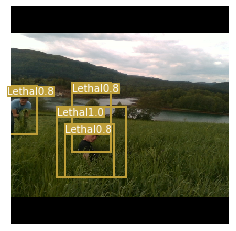

(1) Image
	+ Label: Lethal, Conf: 0.95276
	+ Label: Safe, Conf: 0.83499
	+ Label: Lethal, Conf: 0.75757
	+ Label: Safe, Conf: 0.56338
confidence too low  0.5633825063705444
	+ Label: Lethal, Conf: 0.76395
	+ Label: Safe, Conf: 0.57797
confidence too low  0.5779686570167542
	+ Label: Lethal, Conf: 0.57144
confidence too low  0.5714391469955444


<Figure size 432x288 with 0 Axes>

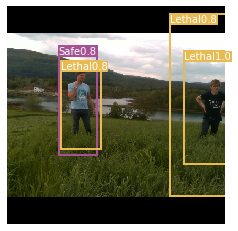

(2) Image
	+ Label: Safe, Conf: 0.98182


<Figure size 432x288 with 0 Axes>

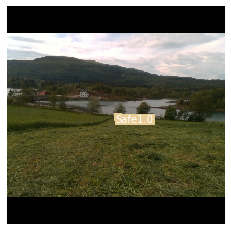

In [59]:
from matplotlib.ticker import NullLocator

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

# Iterate through images and save plot of detections
for img_i, (image, detections) in enumerate(zip(b, outputs)):
    print("(%d) Image" % (img_i))

    # Create plot
    #img = np.array(Image.open(path))
    img = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()
    plt.figure()
    fig, ax = plt.subplots(1)
    #fig.subplots_adjust(left=50, bottom=100, right=1.-50, top=1.-100)
    ax.imshow(img)

    # Draw bounding boxes and labels of detections
    if detections is not None:
        # Rescale boxes to original image
        detections = rescale_boxes(detections, img_size, img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

            print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))

            
            if cls_conf.item()<0.7:
                print("confidence too low " , cls_conf.item())
                continue
            box_w = x2 - x1
            box_h = y2 - y1

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=class_names[int(cls_pred)]+"{:.1f}".format(cls_conf.item()),
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )
        
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.savefig("output/binary_example_yolo{}.png".format(str(img_i)), bbox_inches="tight", pad_inches=0.0,dpi=200)
    plt.show()
    plt.close()